In [0]:
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import time



class AlexNet(nn.Module):

    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.test = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=5)
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        # self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Define CNN Architecture

# In[ ]:


device = 'cuda' if torch.cuda.is_available() else 'cpu'
epochs = 10


#Visualizing CIFAR 10
trainset = torchvision.datasets.CIFAR10(root='./data',download=True)
datanum = len(trainset)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
fig = plt.figure()
ims = np.random.randint(datanum, size=15)

for i in range(15):
    subplot = fig.add_subplot(3,5, i+1)
    subplot.set_xticks([])
    subplot.set_yticks([])
    PILimg, label = trainset[ims[i]]
    subplot.set_title("%s" %classes[label])
    subplot.imshow(PILimg)

plt.show()



# Data
print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


# Model
print('==> Building model..')
net = AlexNet()

net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=10, verbose=True)




# Training
def train(epoch):
    print('\nEpoch: %d' % epoch)
    print('\nTrain:')
    net.train()
    train_loss = 0
    correct = 0
    total = 0
    print_time = -1
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        if time.time()-print_time > 1 or print_time == -1 or batch_idx+1 == len(trainloader):
            print('[%3d/%3d] | Loss: %.3f | Acc: %.3f%% (%d/%d)'%(
                batch_idx+1, len(trainloader), train_loss/(batch_idx+1), 100.*correct/total, correct, total))
            
            print_time = time.time()


# In[ ]:


def test(epoch):
    print('\nTest:')
    global best_acc
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    print_time = -1
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if time.time()-print_time > 1 or print_time == -1 or batch_idx+1 == len(testloader):
                print('[%3d/%3d] | Loss: %.3f | Acc: %.3f%% (%d/%d)'%(
                    batch_idx+1, len(testloader), test_loss/(batch_idx+1), 100.*correct/total, correct, total))
                
                print_time = time.time()
                

    # Save checkpoint.
    acc = 100.*correct/total
    print('Saving..')
    state = {
        'net': net.state_dict(),
        'acc': acc,
        'epoch': epoch,
    }
    if not os.path.isdir('checkpoint'):
        os.mkdir('checkpoint')
    torch.save(state, './checkpoint/alexnet.pt')
    best_acc = acc

    scheduler.step(test_loss/(batch_idx+1))


# In[ ]:


for epoch in range(epochs):
    train(epoch)
    test(epoch)



==> Building model..
==> Resuming from checkpoint..
Files already downloaded and verified
10000 test samples
accuracy:0.50350
Confusion matrix, without normalization
Normalized confusion matrix


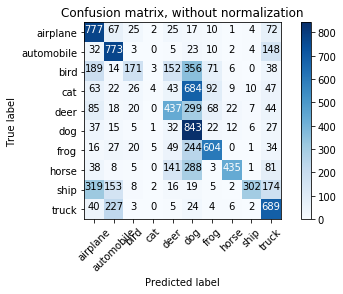

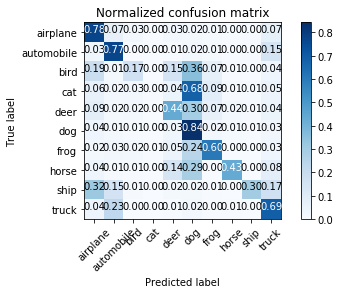

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import os
import time

import sklearn.metrics as skl



def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, format(cm[i, j], fmt),horizontalalignment="center",color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


class AlexNet(nn.Module):

    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.test = nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=5)
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=5),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            # nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 2 * 2, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        # self.classifier = nn.Linear(256, 10)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x



if __name__ == '__main__':
    name_list = ('airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    num_classes = 10


    # Load model and weights
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print('==> Building model..')
    net = AlexNet()
    net = net.to(device)
    if device == 'cuda':
        net = torch.nn.DataParallel(net)
        cudnn.benchmark = True

    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/alexnet.pt')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']
    net.eval()

    # Data
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=234, shuffle=False, num_workers=2)
    print(len(testset), 'test samples')

    ylabel = []
    yhatlabel = []

    for batch_idx, (inputs, targets) in enumerate(testloader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        ylabel = np.concatenate((ylabel, targets.cpu().numpy()))
        yhatlabel = np.concatenate((yhatlabel, predicted.cpu().numpy()))

    # Compute confusion matrix
    cnf_matrix = skl.confusion_matrix(ylabel, yhatlabel)
    np.set_printoptions(precision=2)
    is_correct = (ylabel == yhatlabel)
    acc = np.sum(is_correct * 1) / len(is_correct)
    print('accuracy:%.5f' %acc)


    # Plot non-normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=name_list,
                      title='Confusion matrix, without normalization')

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=name_list, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()


